In [1]:
import pandas as pd
import numpy as np
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict

In [2]:
df_movie = pd.read_csv('ratings.txt')

In [3]:
df_movie.shape

(5043, 6)

In [4]:
df_movie = df_movie.dropna(axis=0,how='any')

In [5]:
print("The number of users is {}".format(len(df_movie['userid'].value_counts())))
print("The number of users is {}".format(len(df_movie['itemid'].value_counts())))
print("The sparcity of the dataset is {}".format(1-df_movie.shape[0]/(len(df_movie['userid'].value_counts())*len(df_movie['itemid'].value_counts()))))

The number of users is 81
The number of users is 79
The sparcity of the dataset is 0.43819346772933265


In [6]:
df_movie.dtypes

userid        int64
itemid       object
rating        int64
Time         object
Location     object
Companion    object
dtype: object

In [7]:
df_movie.head()

,userid,itemid,rating,Time,Location,Companion
148,1003,tt0454876,1,Weekday,Cinema,Alone
149,1003,tt0120912,1,Weekday,Cinema,Alone
150,1003,tt3793764,1,Weekday,Cinema,Alone
151,1003,tt0114148,1,Weekday,Cinema,Alone
152,1003,tt0110357,1,Weekday,Cinema,Alone


In [8]:
df_movie['item'] = df_movie.itemid.str.extract('(\d+)')

In [9]:
del df_movie['itemid']
df_movie = df_movie[['userid','item','rating','Time','Location','Companion']]
context = df_movie.copy()
context['item'] = context['item'].astype('int')
context.iloc[:,3:] = context.iloc[:,3:].astype('object')


In [10]:
context.head()

,userid,item,rating,Time,Location,Companion
148,1003,454876,1,Weekday,Cinema,Alone
149,1003,120912,1,Weekday,Cinema,Alone
150,1003,3793764,1,Weekday,Cinema,Alone
151,1003,114148,1,Weekday,Cinema,Alone
152,1003,110357,1,Weekday,Cinema,Alone


In [11]:
context['Time'].value_counts(),context['Location'].value_counts(),context['Companion'].value_counts()

(Weekend    1845
 Weekday    1750
 Name: Time, dtype: int64,
 Cinema    1963
 Home      1632
 Name: Location, dtype: int64,
 Family     1343
 Alone      1173
 Partner    1079
 Name: Companion, dtype: int64)

In [12]:
Time = {'Weekend':1,'Weekday':2}
Location = {'Cinema':1,
           'Home':2
           }
Companion = {'Family':1,
            'Alone':2,
            'Partner':3}


In [13]:
context['Time'] = context['Time'].map(Time)
context['Location'] = context['Location'].map(Location)
context['Companion'] = context['Companion'].map(Companion)
context_explain = context.copy()

In [14]:
context_explain = context_explain.rename(columns={'userid':'userID','item':'itemID'})

In [15]:
context_explain = context_explain.astype('float')
context_explain.iloc[:,3:] = context_explain.iloc[:,3:].astype('object')
context_test_user = pd.get_dummies(context_explain)


In [16]:
def calculate_correlation(context):
    user_context_correlation = dict()
    context_user_correlation = dict()
    item_context_correlation = dict()
    context_item_correlation = dict()
    
    context_test_user = context.copy()

    cluster_set = list(set(context_test_user['userID'].values))
    for cluster in cluster_set:
        user_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['userID'] == cluster]
        for context_factor in test.columns[3:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            user_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[3:]:
        context_user_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_set:
            test = context_test_user[context_test_user['userID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_user_correlation[context_factor][cluster] = d2

    cluster_item = list(set(context_test_user['itemID'].values))
    for cluster in cluster_item:
        item_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['itemID'] == cluster]
        for context_factor in test.columns[3:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            item_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[3:]:
        context_item_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_item:
            test = context_test_user[context_test_user['itemID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_item_correlation[context_factor][cluster] = d2

    
    return user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation
user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation = calculate_correlation(context_test_user)

/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [17]:
def cosine_similarity(x,y):
    x = np.array(x)
    y = np.array(y)
    where1 = np.isnan(x)
    x[where1] = 0.00001
    where2 = np.isnan(y)
    y[where2] = 0.00001
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom
def cal_similarity_context(x,tg):
    x['sim_context'] = None
    for j in x.index:
        x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
    return x
def select_local(train_data,i):
    df = train_data.copy()
    context_test_rec = cal_similarity_context(df,i)
    local = context_test_rec[context_test_rec['sim_context'] > 0.5]
    media = local.copy()
    localt = media.drop(index=[i])
    return localt,local
def model_train_for_rec(train_data,i):
    localt,local = select_local(train_data,i)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(localt[['userID', 'itemID', 'rating']], reader)
    param_grid = {'n_factors': [25, 30, 35, 40],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    algo = gs.best_estimator['rmse']
    algo.fit(data.build_full_trainset())
    return algo,localt,local

In [65]:
test_try = context_explain.copy()
test_try.iloc[:,3:] = test_try.iloc[:,3:].astype('object')
test_try = pd.get_dummies(test_try)
test_try['context_vector'] = None

for i in test_try.index:
    cluster = test_try['userID'][i]
    test_try['context_vector'][i] = []
    for c in test_try.columns[3:]:
        if test_try[c][i] == 1:
            test_try['context_vector'][i].append(user_context_correlation[cluster][c])



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
usadata_rec = [1082,18,0]
context_info = [1,2,3]
context_info = np.reshape(context_info, (1, len(context_info)))

usadata_rec_all = [1082,18,1,2,3]
usadata_rec_all = np.reshape(usadata_rec_all, (1, len(usadata_rec_all)))
#context_info = np.reshape(context_info, (1, len(context_info)))

In [29]:
def recommend_all(x):
  res = []
  for items in x:
    items  = np.insert(items,2,1) 
    usadata = items
    context = context_explain.copy()

    context.loc[-1] = usadata
    context.iloc[:,3:] = context.iloc[:,3:].astype('object')
    context = pd.get_dummies(context)
    context['context_vector'] = None
    cluster = context['userID'][-1]
    context['context_vector'][-1] = []
    for c in context.columns[3:]:
        if context[c][-1] == 1:
            context['context_vector'][-1].append(user_context_correlation[cluster][c])
    rec_mid = test_try.copy()
    rec_mid.loc[-1] = context.iloc[-1].values
    algo,localt,local = model_train_for_rec(rec_mid,-1)
    rec = algo.predict(usadata[0], usadata[1])
    rec = rec.est
    res.append(rec)
  return np.array(res)
  

In [30]:
recommend_all(usadata_rec_all)

<ipython-input-29-17176cf7fc06>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-17-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])


array([3.14986944])

In [32]:
def ty(x):
  res = []
  for items in x:
    usadata = usadata_rec.copy()
    context = context_explain.copy()
    for item in items:
      usadata.append(item)
    context.loc[-1] = usadata
    context.iloc[:,3:] = context.iloc[:,3:].astype('object')
    context = pd.get_dummies(context)
    context['context_vector'] = None
    cluster = context['userID'][-1]
    context['context_vector'][-1] = []
    for c in context.columns[3:]:
        if context[c][-1] == 1:
            context['context_vector'][-1].append(user_context_correlation[cluster][c])
    rec_mid = test_try.copy()
    rec_mid.loc[-1] = context.iloc[-1].values
    algo,localt,local = model_train_for_rec(rec_mid,-1)
    rec = algo.predict(usadata[0], usadata[1])
    rec = rec.est
    res.append(rec)
  return np.array(res)
  

In [33]:
ty(context_info)

<ipython-input-32-78b21de2d2b0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-17-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])


array([3.1507233])

In [34]:
train = context_explain.iloc[:,3:]
summary = train.median().values.reshape((1,train.shape[1]))
summary.shape
#summary = shap.kmeans(train, 10)

(1, 3)

In [36]:
context_explain

,userID,itemID,rating,Time,Location,Companion
148,1003.0,454876.0,1.0,2,1,2
149,1003.0,120912.0,1.0,2,1,2
150,1003.0,3793764.0,1.0,2,1,2
151,1003.0,114148.0,1.0,2,1,2
152,1003.0,110357.0,1.0,2,1,2
...,...,...,...,...,...,...
5038,1082.0,413267.0,1.0,1,2,3
5039,1082.0,1637706.0,2.0,1,2,3
5040,1082.0,343660.0,1.0,1,2,3
5041,1082.0,1133985.0,1.0,1,2,3


In [40]:
summary_all = context_explain[['userID','itemID','Time','Location','Companion']]
summary_all = summary_all.astype('object')

summary_all_a = summary_all.median().values.reshape((1,summary_all.shape[1]))
#summary_all_a = shap.kmeans(summary_all,10)

summary_all_a.shape
#summary = shap.kmeans(train, 10)

(1, 5)

In [ ]:
import shap
#summary_all_a = summary_all.median().values.reshape((1,summary_all.shape[1]))
explainer1 = shap.KernelExplainer(recommend_all, summary_all_a)
shap_values1 = explainer1.shap_values(summary_all)
np.savetxt('haha_all_new.txt',shap_values1)
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, summary_all)
print(explainer1.expected_value)

In [ ]:
recommend_all(summary_all_a)

In [ ]:
summary = train.median().values.reshape((1,train.shape[1]))
explainer = shap.KernelExplainer(ty, summary)
shap_values = explainer.shap_values(train)
np.savetxt('haha_new.txt',shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train)

In [ ]:
summary = shap.kmeans(train, 10)
summary_all_a = shap.kmeans(summary_all,10)

In [ ]:
import shap
#summary_all_a = summary_all.median().values.reshape((1,summary_all.shape[1]))
explainer1 = shap.KernelExplainer(recommend_all, summary_all_a)
shap_values1 = explainer1.shap_values(summary_all)
np.savetxt('haha_all_new_kmeans.txt',shap_values1)
shap.initjs()
shap.force_plot(explainer1.expected_value, shap_values1, summary_all)
print(explainer1.expected_value)

In [ ]:
summary = train.median().values.reshape((1,train.shape[1]))
explainer = shap.KernelExplainer(ty, summary)
shap_values = explainer.shap_values(train)
np.savetxt('haha_new_kmeans.txt',shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train)

In [49]:
summary_all

,userID,itemID,Time,Location,Companion
148,1003,454876,2,1,2
149,1003,120912,2,1,2
150,1003,3.79376e+06,2,1,2
151,1003,114148,2,1,2
152,1003,110357,2,1,2
...,...,...,...,...,...
5038,1082,413267,1,2,3
5039,1082,1.63771e+06,1,2,3
5040,1082,343660,1,2,3
5041,1082,1.13398e+06,1,2,3



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Intercept 3.0499265789257053
Prediction_local [2.75578094]
Right: 2.4489628400229932


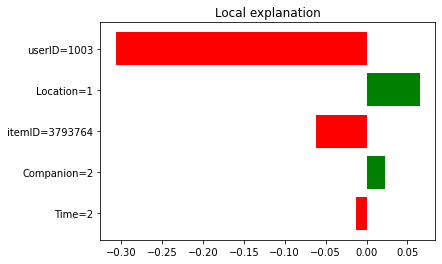

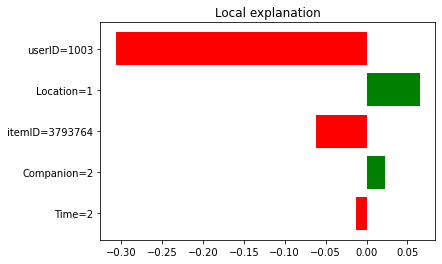

In [56]:
# summary_all = summary_all.copy()
# summary_all['target'] = recommend_all(summary_all.values)

import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(summary_all.values,
                    feature_names = summary_all.columns, 
                    categorical_features= [0,1,2,3,4],                              
                    verbose=True, mode='regression')
exp = explainer.explain_instance(summary_all.iloc[2], 
     recommend_all, num_features=5,num_samples=100)
exp.as_pyplot_figure()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Intercept 2.8116805195077412
Prediction_local [3.6767616]
Right: 4.091952674296233
Figure(432x288)
105.44000434875488


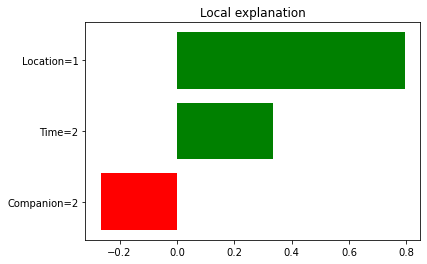

In [57]:
import time
import lime
import lime.lime_tabular
train = train.astype('object')

explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=['Time', 'Location', 'Companion'],
                                                   class_names=['price'], 
                                                   categorical_features=[0,1,2], 
                                                   verbose=True, mode='regression')
t1 = time.time()
exp = explainer.explain_instance(train.iloc[2], 
     ty,num_features=3,num_samples=100)
print(exp.as_pyplot_figure())
t2 = time.time()
print(t2-t1)

In [53]:
t1 = time.time()
ty(context_info)
t2 = time.time()
print(t2-t1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1.1242270469665527


In [54]:
summary_all.head()

,userID,itemID,Time,Location,Companion
148,1003,454876,2,1,2
149,1003,120912,2,1,2
150,1003,3.79376e+06,2,1,2
151,1003,114148,2,1,2
152,1003,110357,2,1,2


In [55]:
train.head()

,Time,Location,Companion
148,2,1,2
149,2,1,2
150,2,1,2
151,2,1,2
152,2,1,2


In [58]:
help(shap)

Help on package shap:

NAME
    shap - # flake8: noqa

PACKAGE CONTENTS
    _cext
    _explanation
    _serializable
    actions (package)
    benchmark (package)
    datasets
    explainers (package)
    links
    maskers (package)
    models (package)
    plots (package)
    utils (package)

SUBMODULES
    other

FUNCTIONS
    unsupported(*args, **kwargs)
        # plotting (only loaded if matplotlib is present)

DATA
    have_matplotlib = True

VERSION
    0.39.0

FILE
    /home/jinfeng/anaconda3/lib/python3.8/site-packages/shap/__init__.py




In [61]:
context_explain

,userID,itemID,rating,Time,Location,Companion
148,1003.0,454876.0,1.0,2,1,2
149,1003.0,120912.0,1.0,2,1,2
150,1003.0,3793764.0,1.0,2,1,2
151,1003.0,114148.0,1.0,2,1,2
152,1003.0,110357.0,1.0,2,1,2
...,...,...,...,...,...,...
5038,1082.0,413267.0,1.0,1,2,3
5039,1082.0,1637706.0,2.0,1,2,3
5040,1082.0,343660.0,1.0,1,2,3
5041,1082.0,1133985.0,1.0,1,2,3


In [ ]:
summary = train.median().values.reshape((1,train.shape[1]))
explainer = shap.KernelExplainer(ty, summary)
shap_values = explainer.shap_values(train.iloc[:30,:])
np.savetxt('/content/gdrive/My Drive/drive/data/Movie_DePaulMovie/haha_new_kmeans.txt',shap_values)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, train)

In [67]:
help(shap)

Help on package shap:

NAME
    shap - # flake8: noqa

PACKAGE CONTENTS
    _cext
    _explanation
    _serializable
    actions (package)
    benchmark (package)
    datasets
    explainers (package)
    links
    maskers (package)
    models (package)
    plots (package)
    utils (package)

SUBMODULES
    other

FUNCTIONS
    unsupported(*args, **kwargs)
        # plotting (only loaded if matplotlib is present)

DATA
    have_matplotlib = True

VERSION
    0.39.0

FILE
    /home/jinfeng/anaconda3/lib/python3.8/site-packages/shap/__init__.py


